# Детекция сигарет на изображениях

## Подключение `ultralytics`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Устанавливаем ultralytics (он предустановлен в google colab, но на всякий случай проверяем)
!pip install ultralytics

## Обзор данных (EDA)

- Все фоторафии имеют размер 640*640 (можно выбрать и другой, нужна кратность 32).
- К каждой фотографии есть аннотация из координат угла bbox и длины и ширины его стенок.

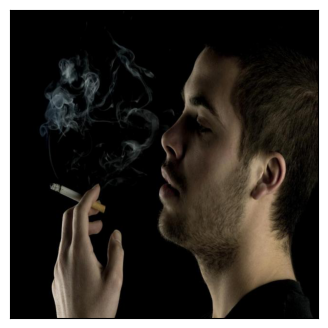

In [ ]:
'''Пример исходного изображения '''
from matplotlib import pyplot as plt


plt.figure(figsize=(4, 4))

plt.plot(131)
img_path = r'/content/drive/MyDrive/Cigarette ML/train/images/-_jpg.rf.56682d1929250f5f9ac2409c8fc92ae2.jpg'
img = plt.imread(img_path)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [ ]:
'''Пример аннотации изображения'''

# аннотация содержит метку класса и координаты bbox
annotation_path = r'/content/drive/MyDrive/Cigarette ML/train/labels/-_jpg.rf.56682d1929250f5f9ac2409c8fc92ae2.txt'
with open(annotation_path, 'r') as annotation:
    print(annotation.read())

0 0.21796875 0.60625 0.2046875 0.13046875


## Выбор модели

Будет использоваться модели `YOLOv8n`.

[Основные характеристики моделей](https://docs.ultralytics.com/models/yolov8/#supported-modes)

## Обучение моделей

In [ ]:
'''Обучение модели YOLOvn'''

from ultralytics import YOLO

# Путь к модели
model_path = r'/content/drive/MyDrive/Cigarette ML/models/best_75.pt'
# Загрузка модели
model = YOLO(model_path)

In [ ]:
# Обучение модели
model.train(data='/content/drive/MyDrive/Cigarette ML/data v2 no aug/data.yaml', epochs=100, imgsz=640, patience=300)

## Сохранения предсказаний

In [ ]:
from pathlib import Path
from ultralytics import YOLO
import os
import cv2
from PIL import Image


class CigaretteDetector:
    '''
    Класс для детекции сигарет на изображениях

    Основное применение - создание bbox на сигаретах.

    Attributes:
        model (YOLO): модель YOLO

    Methods:
        save_one_img() - отрисовывает bbox на одном изображении
        save_move() - отрисовывает bbox на видео

    '''

    def __init__(self, path_to_weight: str | Path):
        self.model = YOLO(path_to_weight)

    def save_one_img(self, home_path: str | Path, path_to_save: str | Path):
        '''
        Метод для детектирования сигарет на одном изображении

        Args:
            home_path (Path): путь к изображению
            path_to_save (Path): путь к директории для сохранения
        '''

        # Делаем предсказание
        res = self.model.predict(home_path)
        res_plotted = res[0].plot()

        # Сохраняем изображение
        imageRGB = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(imageRGB)
        img.save(path_to_save)

    def save_move(self, video_path: str | Path, out_filename: str | Path):
        '''
        Метод для детектирования сигарет на одном изображении

        Args:
            video_path (Path): путь к видео
            out_filename (Path): путь и название файла для сохранения
        '''

        # Инициализируем поток для предсказания
        stream_video = self.model.predict(video_path, stream=True)

        # Берём видео и считываем основные параметры
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')

        # Создаем класс для записи
        out = cv2.VideoWriter(out_filename, fourcc, fps, (width, height))

        #  Обрабатываем кадры
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame = self.model(frame)
                frame = frame[0].plot()
                out.write(frame)
            else:
                break

        # Закрываем потоки
        cap.release()
        out.release()

In [ ]:
# Путь к весам модели
best_model_path = r'/content/drive/MyDrive/Cigarette ML/models/best_75.pt'

In [ ]:
# Инициализируем детектор
cigarete_detector = CigaretteDetector(best_model_path)

In [ ]:
# Путь к тестовому изображению
test_img_path = r'/content/drive/MyDrive/Cigarette ML/test/images/00000_jpg.rf.f17cad7f93edda2752f18bb40a2d2d92.jpg'

# Делаем одиночное предсказание
cigarete_detector.save_move(test_img_path, 'test.jpg')

In [ ]:
'''Пример детектированного изображения'''

# Путь к тестовому изображению
test_img_path = '/content/drive/MyDrive/Cigarette ML/test_raw/00008.jpg'

In [ ]:
# Детектируем сигареты
res = cigarete_detector.model(test_img_path)
res_plotted = res[0].plot()

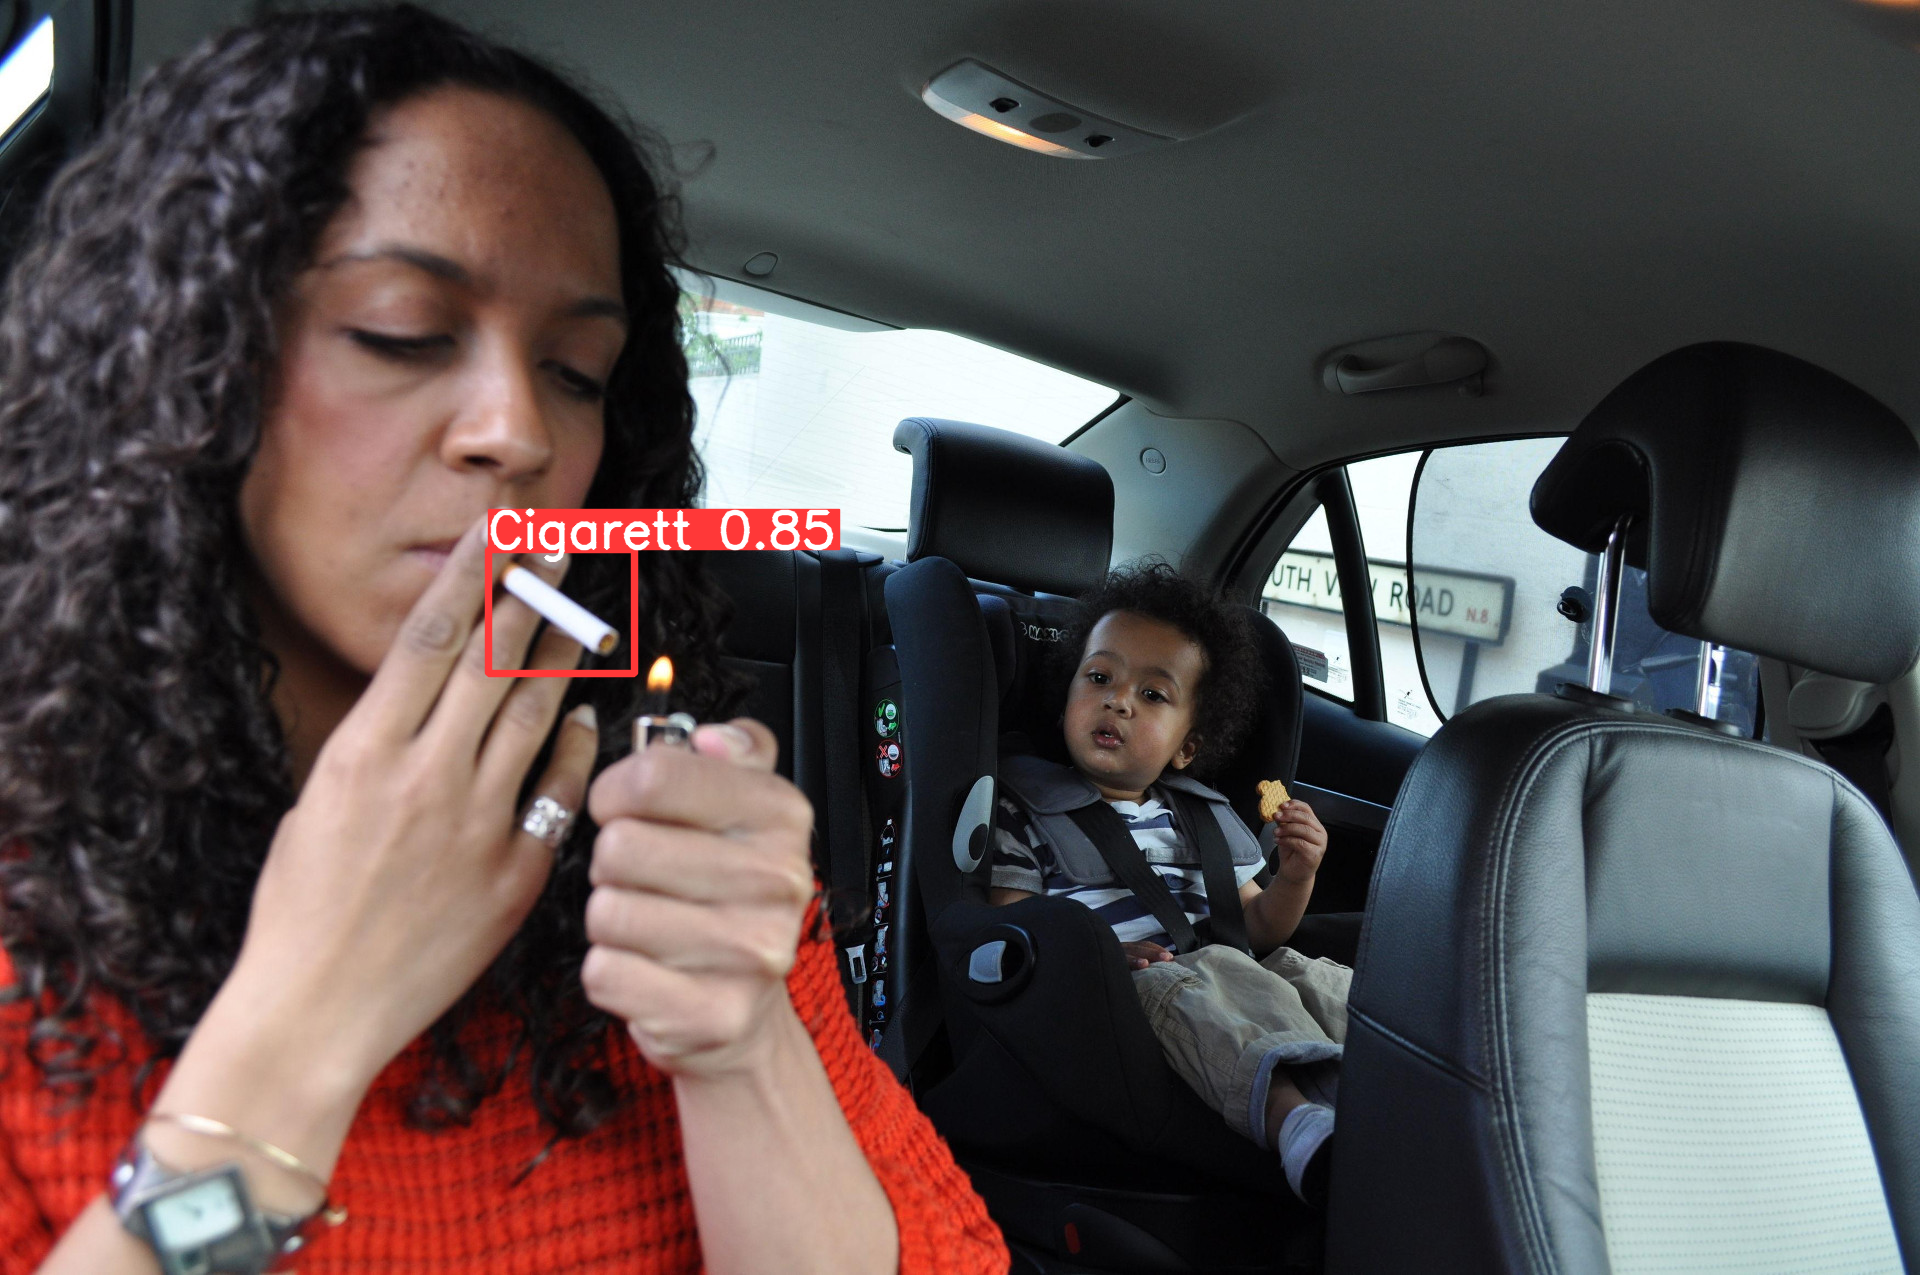

In [ ]:
# вывод изображения
imageRGB = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
img = Image.fromarray(imageRGB)
img

# Детекция сигарет на видео видео

In [ ]:
# Путь к весам модели
best_model_path = r'/content/drive/MyDrive/Cigarette ML/models/best_75.pt'

In [ ]:
# Инициализируем детектор
cigarete_detector = CigaretteDetector(best_model_path)

In [ ]:
# Путь к тестовому видео
test_move_path = r'/content/video_for_detection_cigarette.mp4'

# Делаем одиночное предсказание
cigarete_detector.save_move(test_move_path, 'ready.mp4')